Try to use an NN to classify patients in healthy (class 5) and non healthy (classes 1-4)

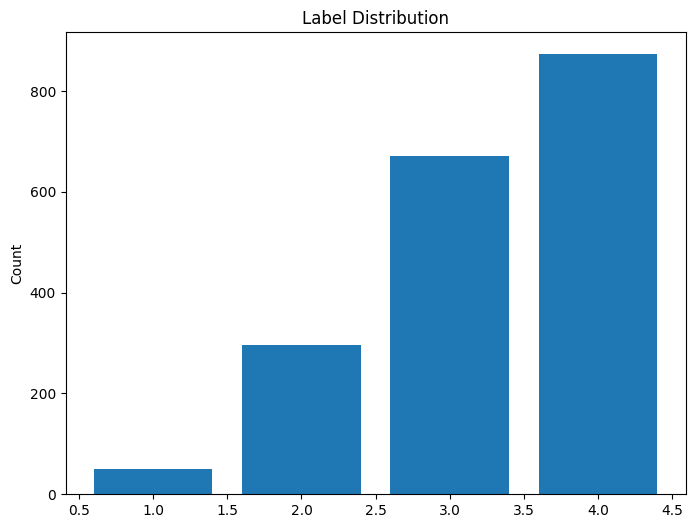

In [5]:
import numpy as np
# Load X and y
X = np.load('X.npy')
y = np.load('y.npy')

n_cl = 4

# select only records with argmax(y) between 0 and 3
indices = np.where(np.argmax(y, axis=1) < n_cl)[0]
X = X[indices]
y = y[indices]
# remove columns from y greater than n_cl
y = y[:, :n_cl]

# Check the distribution of the new labels
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.bar(range(1, y.shape[1] + 1), np.sum(y, axis=0))
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

In [6]:
from sklearn.utils.class_weight import compute_class_weight

# Use all possible class indices for one-hot encoded y
class_weights = compute_class_weight('balanced', classes=np.arange(y.shape[1]), y=y.argmax(axis=1))

# format as a dict class: weight
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(9.279411764705882), 1: np.float64(1.5934343434343434), 2: np.float64(0.7042410714285714), 3: np.float64(0.5420962199312714)}


In [7]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y.argmax(axis=1))


In [8]:
import tensorflow as tf

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,    #0.05               best with 0.001
  decay_steps=50, #100        best with 100
  decay_rate=4, #1              best with 1
  staircase=True)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks(name):
    return [
        tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=200, min_delta=0.001),
        ]

def compile_and_fit(model, name, x_train, y_train, x_test, y_test, optimizer=None, max_epochs=100):

    if optimizer is None:
        optimizer = get_optimizer()

    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model.summary()

    history = model.fit(
            x_train, y_train,
            epochs=max_epochs,
            # batch_size=500,
            validation_data=(x_test, y_test),
            callbacks=get_callbacks(name),
            class_weight=class_weights,
            verbose=2)

    return history

c:\Users\adriano.minora\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       102,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 275,652 (1.05 MB)

 Trainable params: 275,652 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2000
48/48 - 2s - 49ms/step - accuracy: 0.4320 - loss: 2.0635 - val_accuracy: 0.5013 - val_loss: 1.9356
Epoch 2/2000
48/48 - 0s - 7ms/step - accuracy: 0.6691 - loss: 1.5091 - val_accuracy: 0.6544 - val_loss: 1.6215
Epoch 3/2000
48/48 - 0s - 6ms/step - accuracy: 0.7847 - loss: 1.3773 - val_accuracy: 0.7467 - val_loss: 1.5313
Epoch 4/2000
48/48 - 0s - 6ms/step - accuracy: 0.8131 - loss: 1.2740 - val_accuracy: 0.7599 - val_loss: 1.4558
Epoch 5/2000
48/48 - 0s - 7ms/step - accuracy: 0.8415 - loss: 1.2284 - val_accuracy: 0.7836 - val_loss: 1.4173
Epoch 6/2000
48/48 - 0s - 7ms/step - accuracy: 0.8554 - loss: 1.1919 - val_accuracy: 0.7836 - val_loss: 1.3991
Epoch 7/2000
48/48 - 0s - 7ms/step - accuracy: 0.8745 - loss: 1.1606 - val_accuracy: 0.8047 - val_loss: 1.3677
Epoch 8/2000
48/48 - 0s - 7ms/step - accuracy: 0.8798 - loss: 1.1317 - val_accuracy: 0.8074 - val_loss: 1.3458
Epoch 9/2000
48/48 - 0s - 7ms/step - accuracy: 0.8838 - loss: 1.1199 - val_accuracy: 0.8232 - val_loss: 1.3172


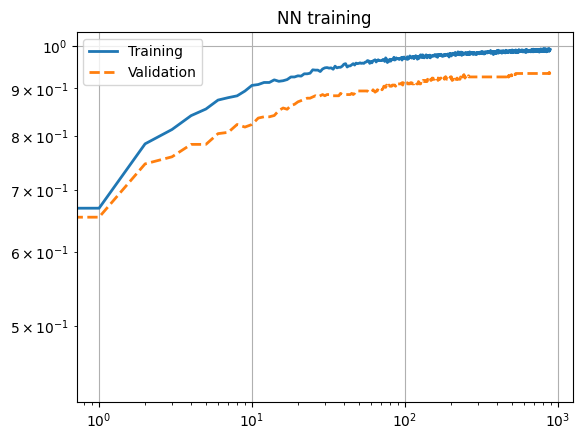

In [9]:
from tensorflow.keras import layers, regularizers

INPUTDIM = X_train.shape[1]
OUTPUTDIM = y_train.shape[1]

n_train=X_train.shape[0]
n_val=X_val.shape[0]

dropout= 0.01
reg = 0.001

NN = tf.keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=(INPUTDIM,),kernel_regularizer = regularizers.l2(reg)),
    layers.Dropout(dropout),
    layers.Dense(256, activation='relu', kernel_regularizer = regularizers.l2(reg)),
    layers.Dropout(dropout),
    layers.Dense(128, activation='relu', kernel_regularizer = regularizers.l2(reg)),
    layers.Dropout(dropout),
    layers.Dense(64, activation='relu', kernel_regularizer = regularizers.l2(reg)),
    layers.Dropout(dropout),
    layers.Dense(OUTPUTDIM, activation='softmax')
])

history = compile_and_fit(NN, 'NN',X_train, y_train, X_val, y_val, max_epochs=2000)

bc     = history.history['accuracy']
val_bc = history.history['val_accuracy']

plt.loglog(range(np.shape(bc)[0]),bc, linewidth=2,)
plt.loglog(range(np.shape(val_bc)[0]),val_bc,'--', linewidth=2,)
plt.title('NN training')
plt.grid(True)
#plt.show(block=False)

plt.legend(('Training','Validation'))
plt.show()



Epoch 893/2000
48/48 - 0s - 9ms/step - accuracy: 0.9914 - loss: 0.7051 - val_accuracy: 0.9340 - val_loss: 0.9454

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
F1 score: 0.9682495006616523


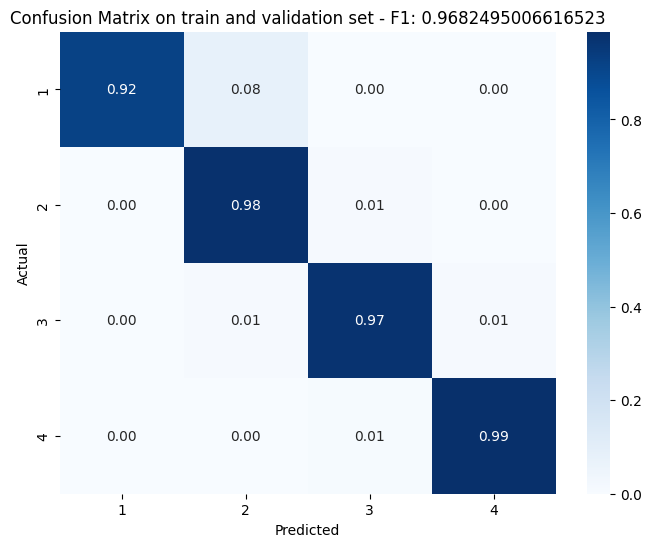

In [10]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

# Example true labels and predicted labels
y_true = np.argmax(np.concatenate((y_val, y_train)), axis=-1)
y_pred = np.argmax(NN.predict(np.concatenate((X_val, X_train))), axis=-1)

# Compute the f1 score
f1 = f1_score(y_true, y_pred, average='macro')
print('F1 score:', f1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(n_cl), normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(1,n_cl+1), yticklabels=range(1,n_cl+1))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix on train and validation set - F1: {f1}')
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
F1 score: 0.8844203563007598


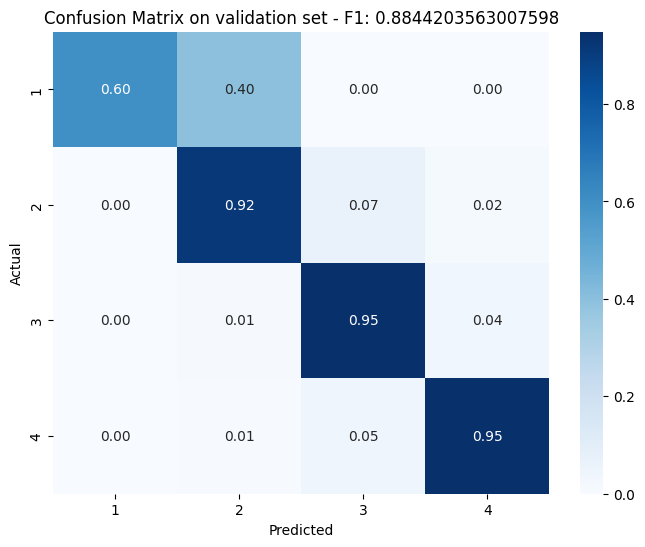

In [11]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

# Example true labels and predicted labels
y_true = np.argmax(y_val, axis=-1)
y_pred = np.argmax(NN.predict(X_val), axis=-1)

# Compute the f1 score
f1 = f1_score(y_true, y_pred, average='macro')
print('F1 score:', f1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(n_cl), normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(1,n_cl+1), yticklabels=range(1,n_cl+1))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix on validation set - F1: {f1}')
plt.show()

In [ ]:
# Save the NN

save = False
if save:
    NN.save('NN_rhythm_categorical_1_4.keras')
    print("Model saved.")
else:
    print("Model not saved.")

Model saved.
